# FMRI תרגיל מסכם – למידת מכונה על נתוני
**שם:** [ירין בן סעדון 206507972 , יאיר קטרון קופרשטין 215027418 , סהר אזולאי 208599084]  

In [23]:
!pip install nilearn

In [24]:
# Importing libraries
import numpy as np
import pandas as pd
import scipy.io
import os
import time
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import LeaveOneOut, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
np.random.seed(42)

In [65]:
# Loading and preprocessing movie clips

def load_and_preprocess_fmri_mat(subject_id, data_array, label_type='movie'):

    # Loads and preprocesses the fMRI data for a single subject.

    # Parameters:
    #- subject_id (int): index of the subject (0 to 169)
    #- data_array (np.ndarray): shape (170, 14, T, N_regions), full fMRI dataset
    #- label_type (str): 'movie' or 'rest' (optional, currently unused)

    # Returns:
    #- X (np.ndarray): features, shape (28, T*N_regions)
    #- y (np.ndarray): labels, shape (28,)
    #- unique_labels (np.ndarray): list of unique clip indices (0–13)

    subject_matrix = data_array[subject_id]  # Extract this subject's data, shape: (14 clips, T, N_regions)
    n_clips = subject_matrix.shape[0]        # Expected: 14 clips per subject

    X_list = []  # To store flattened features
    y_list = []  # To store labels (clip index)

    for clip_idx in range(n_clips):
        clip_data = subject_matrix[clip_idx]  # shape: (T, N_regions)

        # Only taking the first and last 5 seconds
        start_segment = clip_data[:5]         # First 5 timepoints, shape: (5, N_regions)
        end_segment = clip_data[-5:]          # Last 5 timepoints, shape: (5, N_regions)

        # Flatten both and append to list (shape: (5 * N_regions,))
        X_list.append(start_segment.flatten())
        X_list.append(end_segment.flatten())

        # Add corresponding labels - each segment gets the clip index
        y_list.append(clip_idx)
        y_list.append(clip_idx)

    X = np.array(X_list)       # Final shape: (28, 5 * N_regions)
    y = np.array(y_list)       # Final shape: (28,)
    unique_labels = np.unique(y)

    print(f"Subject {subject_id}: x shape: {X.shape}, y shape: {y.shape}")
    return X, y, unique_labels

In [66]:
# Loading movie & rest data files
movie_DAN = scipy.io.loadmat("data_movie_DAN.mat")["data_movie_DAN"]
movie_DMN = scipy.io.loadmat("data_movie_DMN.mat")["data_movie_DMN"]
movie_VIS = scipy.io.loadmat("data_movie_VIS.mat")["data_movie_VIS"]

rest_DAN = scipy.io.loadmat("data_rest_DAN.mat")["data_rest_DAN"]
rest_DMN = scipy.io.loadmat("data_rest_DMN.mat")["data_rest_DMN"]
rest_VIS = scipy.io.loadmat("data_rest_VIS.mat")["data_rest_VIS"]

In [27]:
# Dictionary holding subject-wise preprocessed movie data
subject_data_movie_DAN = {subj: load_and_preprocess_fmri_mat(subj, movie_DAN, label_type='movie') for subj in range(170)}
subject_data_movie_DMN = {subj: load_and_preprocess_fmri_mat(subj, movie_DMN, label_type='movie') for subj in range(170)}
subject_data_movie_VIS = {subj: load_and_preprocess_fmri_mat(subj, movie_VIS, label_type='movie') for subj in range(170)}

# Dictionary holding subject-wise preprocessed rest data
subject_data_rest_DAN = {subj: load_and_preprocess_fmri_mat(subj, rest_DAN, label_type='rest') for subj in range(170)}
subject_data_rest_DMN = {subj: load_and_preprocess_fmri_mat(subj, rest_DMN, label_type='rest') for subj in range(170)}
subject_data_rest_VIS = {subj: load_and_preprocess_fmri_mat(subj, rest_VIS, label_type='rest') for subj in range(170)}


Subject 0: X shape: (28, 170), y shape: (28,)
Subject 1: X shape: (28, 170), y shape: (28,)
Subject 2: X shape: (28, 170), y shape: (28,)
Subject 3: X shape: (28, 170), y shape: (28,)
Subject 4: X shape: (28, 170), y shape: (28,)
Subject 5: X shape: (28, 170), y shape: (28,)
Subject 6: X shape: (28, 170), y shape: (28,)
Subject 7: X shape: (28, 170), y shape: (28,)
Subject 8: X shape: (28, 170), y shape: (28,)
Subject 9: X shape: (28, 170), y shape: (28,)
Subject 10: X shape: (28, 170), y shape: (28,)
Subject 11: X shape: (28, 170), y shape: (28,)
Subject 12: X shape: (28, 170), y shape: (28,)
Subject 13: X shape: (28, 170), y shape: (28,)
Subject 14: X shape: (28, 170), y shape: (28,)
Subject 15: X shape: (28, 170), y shape: (28,)
Subject 16: X shape: (28, 170), y shape: (28,)
Subject 17: X shape: (28, 170), y shape: (28,)
Subject 18: X shape: (28, 170), y shape: (28,)
Subject 19: X shape: (28, 170), y shape: (28,)
Subject 20: X shape: (28, 170), y shape: (28,)
Subject 21: X shape: (2

# Part 1 - Movie

In [63]:
# Combining all subjects' data into one dataset (X, y), for movie classification using either the first or last 5 seconds of each clip

def build_full_dataset(subject_data_dict, clip_part='start'):

    # Combine data from all subjects into a single dataset (X, y)

    # Parameters:
    # - subject_data_dict: dict of {subject_id: (X_subj, y_subj, unique_labels)}
    # - clip_part: 'start' or 'end' – whether to use first or last 5 seconds of each clip

    # Returns:
    #- X (np.ndarray): Combined feature matrix, shape: (n_subjects * n_clips, features)
    #- y (np.ndarray): Corresponding labels, shape: (n_subjects * n_clips,)

    X_all = []
    y_all = []

    for subj_id, (X_subj, y_subj, _) in subject_data_dict.items():
        if clip_part == 'start':
            # Start of each clip: selecting only the even indices (0, 2, 4...) corresponding to clip start
            X_part = X_subj[::2]
            y_part = y_subj[::2]
        elif clip_part == 'end':
            # End of each clip: selecting only the odd indices (1, 3, 5...) corresponding to clip end
            X_part = X_subj[1::2]
            y_part = y_subj[1::2]
        else:
            raise ValueError("clip_part must be 'start' or 'end'")

        # Append each subject’s selected data
        X_all.append(X_part)
        y_all.append(y_part)

    # Combining all subjects into one matrix
    X = np.vstack(X_all)
    y = np.hstack(y_all)

    print(f"[{clip_part.upper()}] Combined X shape: {X.shape}, y shape: {y.shape}")
    return X, y

In [29]:
# Running for network VIS (movie data)
X_vis_start, y_vis_start = build_full_dataset(subject_data_movie_VIS, clip_part='start')
X_vis_end, y_vis_end = build_full_dataset(subject_data_movie_VIS, clip_part='end')

# Running for network DAN (movie data)
X_dan_start, y_dan_start = build_full_dataset(subject_data_movie_DAN, clip_part='start')
X_dan_end, y_dan_end = build_full_dataset(subject_data_movie_DAN, clip_part='end')

# Running for network DMN (movie data)
X_dmn_start, y_dmn_start = build_full_dataset(subject_data_movie_DMN, clip_part='start')
X_dmn_end, y_dmn_end = build_full_dataset(subject_data_movie_DMN, clip_part='end')

[START] Combined X shape: (2380, 235), y shape: (2380,)
[END] Combined X shape: (2380, 235), y shape: (2380,)
[START] Combined X shape: (2380, 170), y shape: (2380,)
[END] Combined X shape: (2380, 170), y shape: (2380,)
[START] Combined X shape: (2380, 340), y shape: (2380,)
[END] Combined X shape: (2380, 340), y shape: (2380,)


In [30]:
#SVM with k-fold

def train_svm_kfold(X, y, k=10):

    # Train SVM classifier using K-Fold CV with clipping, imputation, and scaling.

    X = np.clip(X, -1e6, 1e6)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    clf = SVC(kernel='linear', C=1)

    y_pred = []
    y_true = []

    for train_idx, test_idx in kf.split(X):
        imputer = SimpleImputer(strategy='mean')
        X_train = imputer.fit_transform(X[train_idx])
        X_test = imputer.transform(X[test_idx])

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        clf.fit(X_train, y[train_idx])
        preds = clf.predict(X_test)

        y_pred.extend(preds)
        y_true.extend(y[test_idx])

    return accuracy_score(y_true, y_pred)

# Calculating for all networks (VIS, DAN, DMN) for both start and end

def evaluate_svm_all_networks():
    results = {}

    networks = {
        "VIS": (X_vis_start, y_vis_start, X_vis_end, y_vis_end),
        "DAN": (X_dan_start, y_dan_start, X_dan_end, y_dan_end),
        "DMN": (X_dmn_start, y_dmn_start, X_dmn_end, y_dmn_end),
    }

    for net_name, (X_start, y_start, X_end, y_end) in networks.items():
        acc_start = train_svm_kfold(X_start, y_start)
        acc_end = train_svm_kfold(X_end, y_end)
        results[net_name] = {"start": acc_start, "end": acc_end}

    return results

#Running model and showing accuracy scores
svm_results = evaluate_svm_all_networks()
for net, scores in svm_results.items():
    print(f"{net} - SVM Accuracy | Start: {scores['start']:.4f} | End: {scores['end']:.4f}")

VIS - SVM Accuracy | Start: 0.4546 | End: 0.4609
DAN - SVM Accuracy | Start: 0.4824 | End: 0.5109
DMN - SVM Accuracy | Start: 0.7920 | End: 0.7630


In [31]:
#KNN with k-fold

def train_knn_kfold(X, y, k=10, n_neighbors=5):

    # Train KNN classifier using K-Fold CV with clipping, imputation, and scaling.

    X = np.clip(X, -1e6, 1e6)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)

    y_pred = []
    y_true = []

    for train_idx, test_idx in kf.split(X):
        imputer = SimpleImputer(strategy='mean')
        X_train = imputer.fit_transform(X[train_idx])
        X_test = imputer.transform(X[test_idx])

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        clf.fit(X_train, y[train_idx])
        preds = clf.predict(X_test)

        y_pred.extend(preds)
        y_true.extend(y[test_idx])

    return accuracy_score(y_true, y_pred)

# Calculating for all networks (VIS, DAN, DMN) for both start and end

def evaluate_knn_all_networks():
    results = {}

    networks = {
        "VIS": (X_vis_start, y_vis_start, X_vis_end, y_vis_end),
        "DAN": (X_dan_start, y_dan_start, X_dan_end, y_dan_end),
        "DMN": (X_dmn_start, y_dmn_start, X_dmn_end, y_dmn_end),
    }

    for net_name, (X_start, y_start, X_end, y_end) in networks.items():
        acc_start = train_knn_kfold(X_start, y_start)
        acc_end = train_knn_kfold(X_end, y_end)
        results[net_name] = {"start": acc_start, "end": acc_end}

    return results

#Running model and showing accuracy scores
knn_results = evaluate_knn_all_networks()
for net, scores in knn_results.items():
    print(f"{net} - KNN Accuracy | Start: {scores['start']:.4f} | End: {scores['end']:.4f}")

VIS - KNN Accuracy | Start: 0.2777 | End: 0.2979
DAN - KNN Accuracy | Start: 0.3025 | End: 0.3118
DMN - KNN Accuracy | Start: 0.5849 | End: 0.5824


In [32]:
#QDA with k-fold

def evaluate_qda_kfold(X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    qda = QDA()
    y_true = []
    y_pred = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        qda.fit(X_train, y_train)
        y_pred.extend(qda.predict(X_test))
        y_true.extend(y_test)

    return accuracy_score(y_true, y_pred)

# Calculating for all networks (VIS, DAN, DMN) for both start and end

def evaluate_qda_for_all_networks():
    results = {}

    networks = {
        "VIS": (X_vis_start, y_vis_start, X_vis_end, y_vis_end),
        "DAN": (X_dan_start, y_dan_start, X_dan_end, y_dan_end),
        "DMN": (X_dmn_start, y_dmn_start, X_dmn_end, y_dmn_end),
    }

    for net_name, (X_start, y_start, X_end, y_end) in networks.items():
        acc_start = evaluate_qda_kfold(X_start, y_start)
        acc_end = evaluate_qda_kfold(X_end, y_end)
        results[net_name] = {"start": acc_start, "end": acc_end}

    return results

#Running model and showing accuracy scores
qda_results = evaluate_qda_for_all_networks()
for net, scores in qda_results.items():
    print(f"{net} - QDA Accuracy | Start: {scores['start']:.4f} | End: {scores['end']:.4f}")

VIS - QDA Accuracy | Start: 0.0735 | End: 0.0706
DAN - QDA Accuracy | Start: 0.0807 | End: 0.0777
DMN - QDA Accuracy | Start: 0.0790 | End: 0.0807


In [33]:
#LDA with k-fold

def train_lda_kfold(X, y, k=10):

    # Train LDA classifier using K-Fold CV with clipping, imputation, and scaling.

    X = np.clip(X, -1e6, 1e6)  # clip extreme values
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    clf = LDA()

    y_pred = []
    y_true = []

    for train_idx, test_idx in kf.split(X):
        imputer = SimpleImputer(strategy='mean')
        X_train = imputer.fit_transform(X[train_idx])
        X_test = imputer.transform(X[test_idx])

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        clf.fit(X_train, y[train_idx])
        preds = clf.predict(X_test)

        y_pred.extend(preds)
        y_true.extend(y[test_idx])

    return accuracy_score(y_true, y_pred)

# Calculating for all networks (VIS, DAN, DMN) for both start and end

def evaluate_lda_all_networks():
    results = {}

    networks = {
        "VIS": (X_vis_start, y_vis_start, X_vis_end, y_vis_end),
        "DAN": (X_dan_start, y_dan_start, X_dan_end, y_dan_end),
        "DMN": (X_dmn_start, y_dmn_start, X_dmn_end, y_dmn_end),
    }

    for net_name, (X_start, y_start, X_end, y_end) in networks.items():
        acc_start = train_lda_kfold(X_start, y_start)
        acc_end = train_lda_kfold(X_end, y_end)
        results[net_name] = {"start": acc_start, "end": acc_end}

    return results

#Running model and showing accuracy scores
lda_results = evaluate_lda_all_networks()
for net, scores in lda_results.items():
    print(f"{net} - LDA Accuracy | Start: {scores['start']:.4f} | End: {scores['end']:.4f}")

VIS - LDA Accuracy | Start: 0.5223 | End: 0.5420
DAN - LDA Accuracy | Start: 0.5550 | End: 0.5975
DMN - LDA Accuracy | Start: 0.8609 | End: 0.8416


In [34]:
#Naive Bayes with k-fold

def evaluate_naive_bayes_kfold(X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    nb = GaussianNB()
    y_true = []
    y_pred = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        nb.fit(X_train, y_train)
        y_pred.extend(nb.predict(X_test))
        y_true.extend(y_test)

    return accuracy_score(y_true, y_pred)

# Calculating for all networks (VIS, DAN, DMN) for both start and end

def evaluate_naive_bayes_for_all_networks():
    results = {}

    networks = {
        "VIS": (X_vis_start, y_vis_start, X_vis_end, y_vis_end),
        "DAN": (X_dan_start, y_dan_start, X_dan_end, y_dan_end),
        "DMN": (X_dmn_start, y_dmn_start, X_dmn_end, y_dmn_end),
    }

    for net_name, (X_start, y_start, X_end, y_end) in networks.items():
        acc_start = evaluate_naive_bayes_kfold(X_start, y_start)
        acc_end = evaluate_naive_bayes_kfold(X_end, y_end)
        results[net_name] = {"start": acc_start, "end": acc_end}

    return results

#Running model and showing accuracy scores
naive_bayes_results = evaluate_naive_bayes_for_all_networks()
for net, scores in naive_bayes_results.items():
    print(f"{net} - Naive Bayes Accuracy | Start: {scores['start']:.4f} | End: {scores['end']:.4f}")

VIS - Naive Bayes Accuracy | Start: 0.0702 | End: 0.0710
DAN - Naive Bayes Accuracy | Start: 0.3172 | End: 0.3550
DMN - Naive Bayes Accuracy | Start: 0.5290 | End: 0.5462


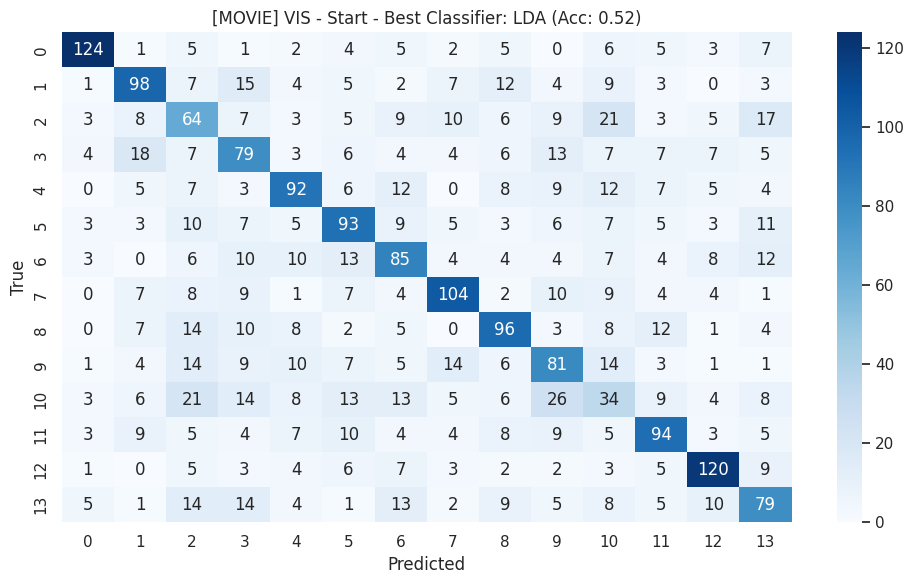

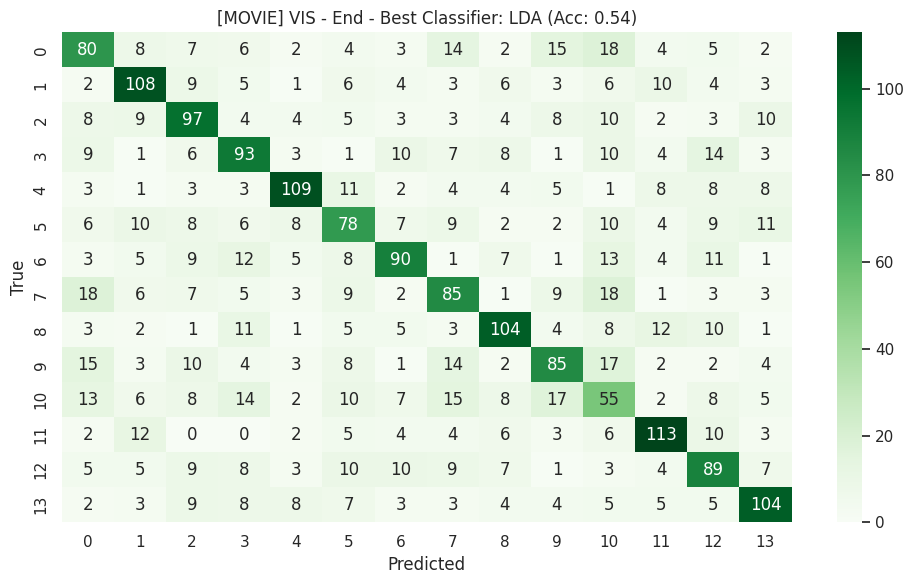

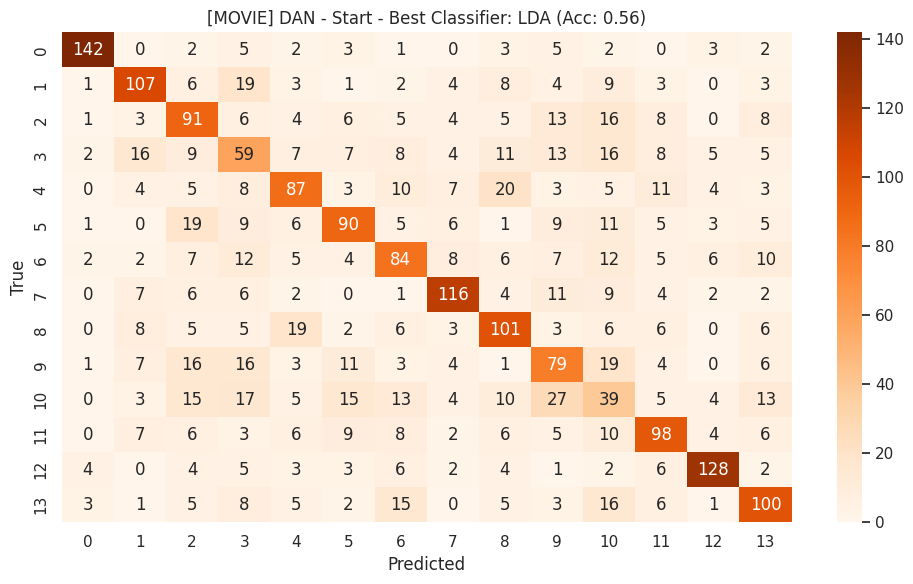

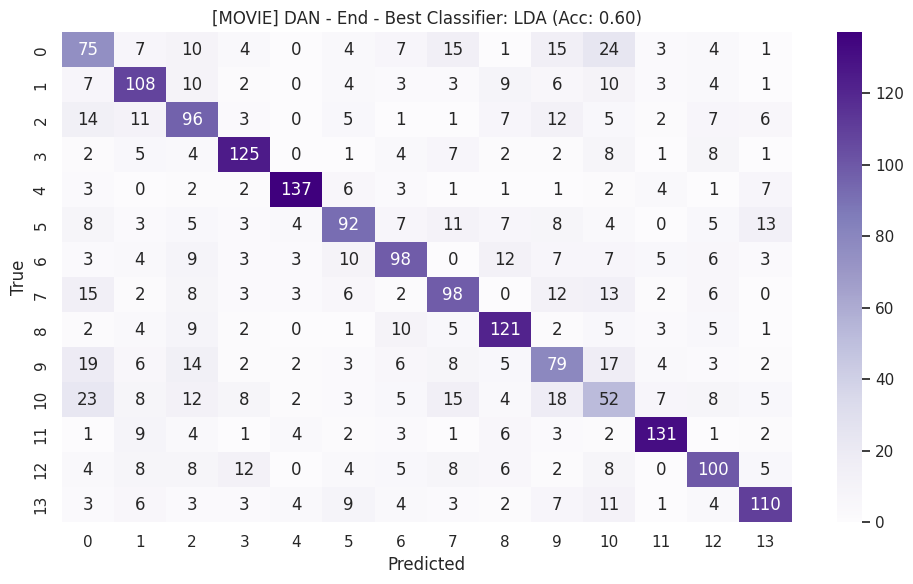

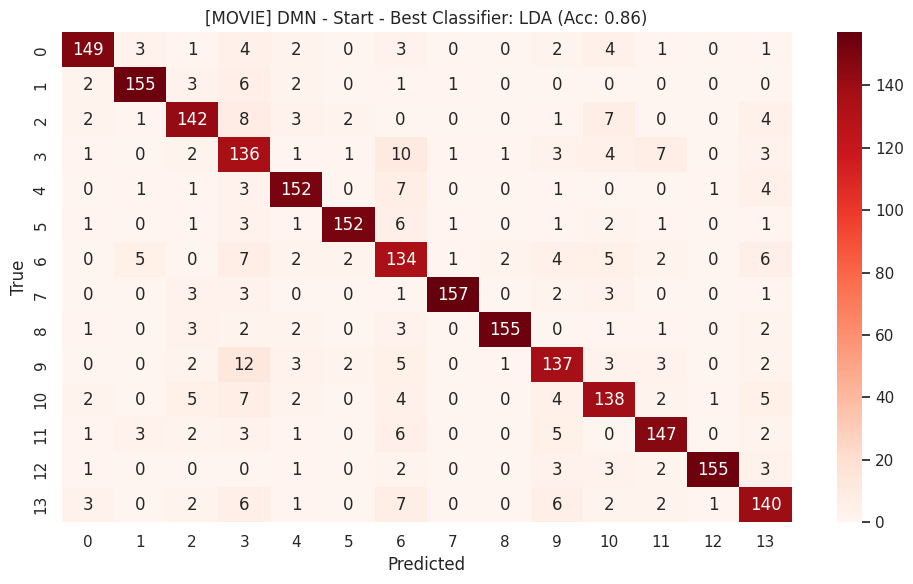

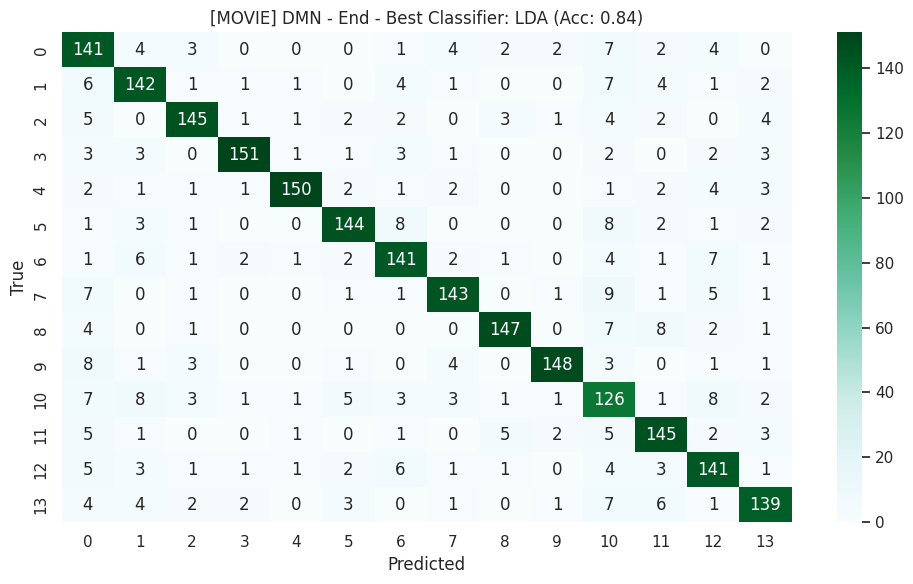

In [35]:
# Defining colors for each matrix
color_maps = ["Blues", "Greens", "Oranges", "Purples", "Reds", "BuGn"]

# Function to identify the best classifier
def best_classifier_name(accuracy_dict):
    return max(accuracy_dict.items(), key=lambda x: x[1])[0]

# Funcion to calculate confusion matrix
def compute_confusion_matrix(X, y, clf_name):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    if clf_name == "QDA":
        clf = QDA()
    elif clf_name == "NB":
        clf = GaussianNB()
    elif clf_name == "LDA":
        clf = LDA()
    elif clf_name == "KNN":
        clf = KNeighborsClassifier(n_neighbors=5)
    elif clf_name == "SVM":
        clf = SVC(kernel='linear', C=1)
    else:
        raise ValueError("Unknown classifier")

    # Data pre-treatment
    X = np.clip(X, -1e6, 1e6)
    imputer_full = SimpleImputer(strategy='mean')
    X = imputer_full.fit_transform(X)

    y_true = []
    y_pred = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

        y_true.extend(y_test)
        y_pred.extend(preds)

    return confusion_matrix(y_true, y_pred)

# Build the movie accuracy dictionary
all_accuracies = {
    "VIS": {
        "start": {
            "QDA": qda_results["VIS"]["start"],
            "NB": naive_bayes_results["VIS"]["start"],
            "LDA": lda_results["VIS"]["start"],
            "KNN": knn_results["VIS"]["start"],
            "SVM": svm_results["VIS"]["start"]
        },
        "end": {
            "QDA": qda_results["VIS"]["end"],
            "NB": naive_bayes_results["VIS"]["end"],
            "LDA": lda_results["VIS"]["end"],
            "KNN": knn_results["VIS"]["end"],
            "SVM": svm_results["VIS"]["end"]
        }
    },
    "DAN": {
        "start": {
            "QDA": qda_results["DAN"]["start"],
            "NB": naive_bayes_results["DAN"]["start"],
            "LDA": lda_results["DAN"]["start"],
            "KNN": knn_results["DAN"]["start"],
            "SVM": svm_results["DAN"]["start"]
        },
        "end": {
            "QDA": qda_results["DAN"]["end"],
            "NB": naive_bayes_results["DAN"]["end"],
            "LDA": lda_results["DAN"]["end"],
            "KNN": knn_results["DAN"]["end"],
            "SVM": svm_results["DAN"]["end"]
        }
    },
    "DMN": {
        "start": {
            "QDA": qda_results["DMN"]["start"],
            "NB": naive_bayes_results["DMN"]["start"],
            "LDA": lda_results["DMN"]["start"],
            "KNN": knn_results["DMN"]["start"],
            "SVM": svm_results["DMN"]["start"]
        },
        "end": {
            "QDA": qda_results["DMN"]["end"],
            "NB": naive_bayes_results["DMN"]["end"],
            "LDA": lda_results["DMN"]["end"],
            "KNN": knn_results["DMN"]["end"],
            "SVM": svm_results["DMN"]["end"]
        }
    }
}


# Confusion matrix for the best classifier for each network for both start and end
cm_index = 0
for net in ["VIS", "DAN", "DMN"]:
    for part in ["start", "end"]:
        best_clf = best_classifier_name(all_accuracies[net][part])
        X = eval(f"X_{net.lower()}_{part}")
        y = eval(f"y_{net.lower()}_{part}")

        cm = compute_confusion_matrix(X, y, best_clf)

        cmap = color_maps[cm_index % len(color_maps)]
        cm_index += 1

        accuracy = all_accuracies[net][part][best_clf]

        plt.figure(figsize=(10, 6))
        sns.heatmap(cm, cmap=cmap, fmt="d", annot=True)
        plt.title(f"[MOVIE] {net} - {part.capitalize()} - Best Classifier: {best_clf} (Acc: {accuracy:.2f})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()


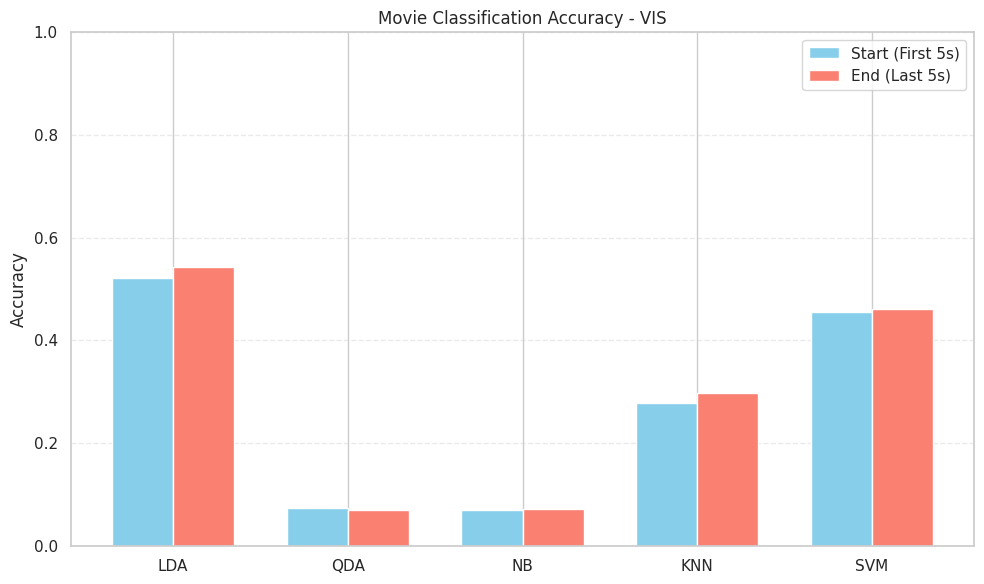

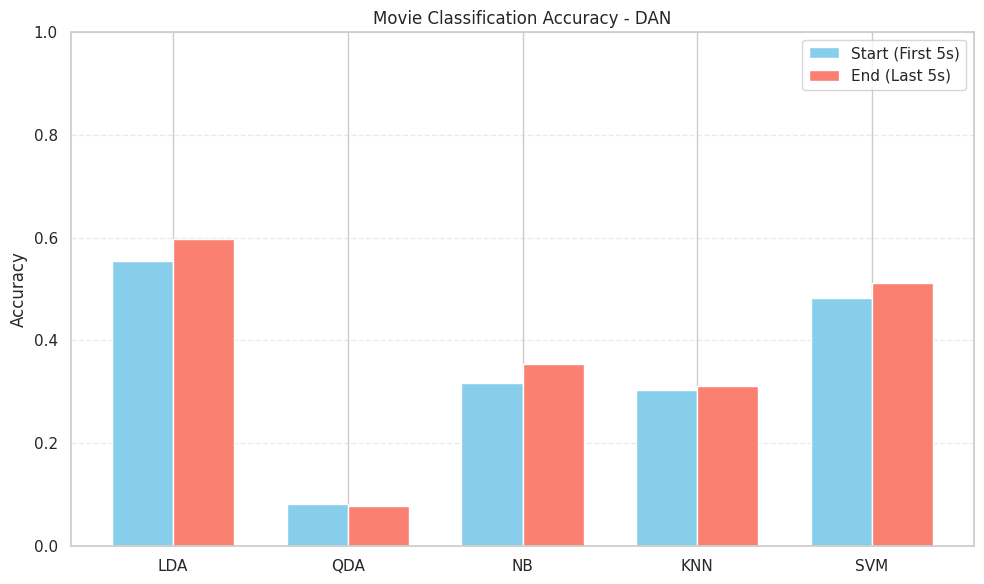

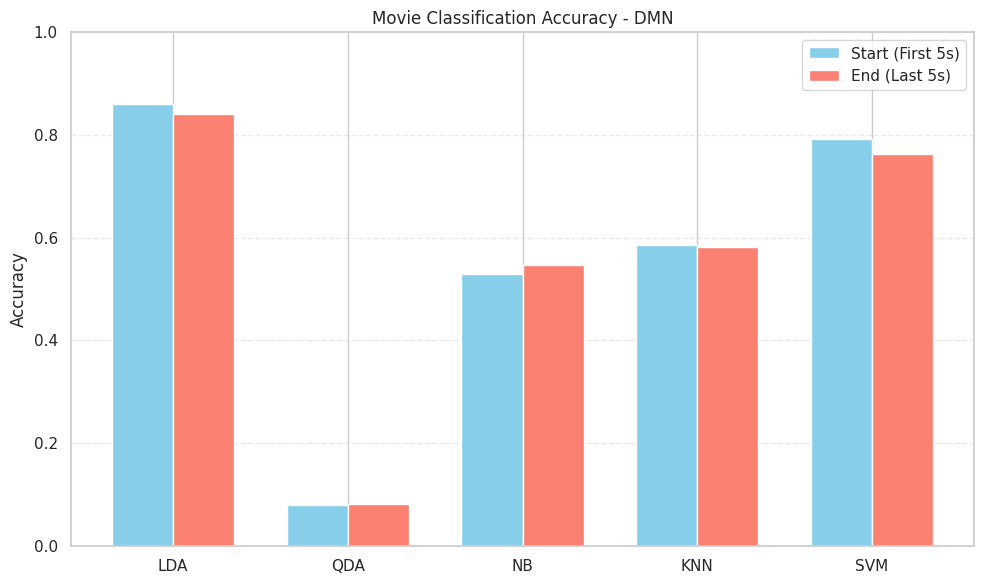

In [36]:
# Plot movie classification accuracy
def plot_movie_accuracy_bars(all_accuracies):
    classifiers = ["LDA", "QDA", "NB", "KNN", "SVM"]
    networks = ["VIS", "DAN", "DMN"]

    for net in networks:
        start_scores = [all_accuracies[net]["start"][clf] for clf in classifiers]
        end_scores = [all_accuracies[net]["end"][clf] for clf in classifiers]

        x = np.arange(len(classifiers))
        width = 0.35

        plt.figure(figsize=(10, 6))
        plt.bar(x - width/2, start_scores, width, label='Start (First 5s)', color='skyblue')
        plt.bar(x + width/2, end_scores, width, label='End (Last 5s)', color='salmon')

        plt.xticks(x, classifiers)
        plt.ylim(0, 1)
        plt.ylabel("Accuracy")
        plt.title(f"Movie Classification Accuracy - {net}")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

plot_movie_accuracy_bars(all_accuracies)

# Part 2 - Rest

In [37]:
# Run for network VIS (rest data)
X_vis_rest_start, y_vis_rest_start = build_full_dataset(subject_data_rest_VIS, clip_part='start')
X_vis_rest_end, y_vis_rest_end = build_full_dataset(subject_data_rest_VIS, clip_part='end')

# Run for network DAN (rest data)
X_dan_rest_start, y_dan_rest_start = build_full_dataset(subject_data_rest_DAN, clip_part='start')
X_dan_rest_end, y_dan_rest_end = build_full_dataset(subject_data_rest_DAN, clip_part='end')

# Run for network DMN (rest data)
X_dmn_rest_start, y_dmn_rest_start = build_full_dataset(subject_data_rest_DMN, clip_part='start')
X_dmn_rest_end, y_dmn_rest_end = build_full_dataset(subject_data_rest_DMN, clip_part='end')


[START] Combined X shape: (2380, 235), y shape: (2380,)
[END] Combined X shape: (2380, 235), y shape: (2380,)
[START] Combined X shape: (2380, 170), y shape: (2380,)
[END] Combined X shape: (2380, 170), y shape: (2380,)
[START] Combined X shape: (2380, 340), y shape: (2380,)
[END] Combined X shape: (2380, 340), y shape: (2380,)


In [38]:
#SVM with k-fold

def train_svm_kfold(X, y, k=10):

    # Train SVM classifier using K-Fold CV with clipping, imputation, and scaling.

    X = np.clip(X, -1e6, 1e6)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    clf = SVC(kernel='linear', C=1)

    y_pred = []
    y_true = []

    for train_idx, test_idx in kf.split(X):
        imputer = SimpleImputer(strategy='mean')
        X_train = imputer.fit_transform(X[train_idx])
        X_test = imputer.transform(X[test_idx])

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        clf.fit(X_train, y[train_idx])
        preds = clf.predict(X_test)

        y_pred.extend(preds)
        y_true.extend(y[test_idx])

    return accuracy_score(y_true, y_pred)

# Calculating for all networks (VIS, DAN, DMN) for both start and end

def evaluate_svm_rest_networks():
    results = {}

    networks = {
        "VIS": (X_vis_rest_start, y_vis_rest_start, X_vis_rest_end, y_vis_rest_end),
        "DAN": (X_dan_rest_start, y_dan_rest_start, X_dan_rest_end, y_dan_rest_end),
        "DMN": (X_dmn_rest_start, y_dmn_rest_start, X_dmn_rest_end, y_dmn_rest_end),
    }

    for net_name, (X_start, y_start, X_end, y_end) in networks.items():
        acc_start = train_svm_kfold(X_start, y_start)
        acc_end = train_svm_kfold(X_end, y_end)
        results[net_name] = {"start": acc_start, "end": acc_end}

    return results

#Running model and showing accuracy scores
svm_rest_results = evaluate_svm_rest_networks()
for net, scores in svm_rest_results.items():
    print(f"[REST] {net} - SVM Accuracy | Start: {scores['start']:.4f} | End: {scores['end']:.4f}")

[REST] VIS - SVM Accuracy | Start: 0.4525 | End: 0.1508
[REST] DAN - SVM Accuracy | Start: 0.4521 | End: 0.1479
[REST] DMN - SVM Accuracy | Start: 0.7416 | End: 0.2479


In [39]:
#QDA with k-fold

def evaluate_qda_kfold(X, y):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    qda = QDA()
    y_true = []
    y_pred = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        qda.fit(X_train, y_train)
        y_pred.extend(qda.predict(X_test))
        y_true.extend(y_test)

    return accuracy_score(y_true, y_pred)

# Calculating for all networks (VIS, DAN, DMN) for both start and end

def evaluate_qda_rest_networks():
    results = {}

    networks = {
        "VIS": (X_vis_rest_start, y_vis_rest_start, X_vis_rest_end, y_vis_rest_end),
        "DAN": (X_dan_rest_start, y_dan_rest_start, X_dan_rest_end, y_dan_rest_end),
        "DMN": (X_dmn_rest_start, y_dmn_rest_start, X_dmn_rest_end, y_dmn_rest_end),
    }

    for net_name, (X_start, y_start, X_end, y_end) in networks.items():
        acc_start = evaluate_qda_kfold(X_start, y_start)
        acc_end = evaluate_qda_kfold(X_end, y_end)
        results[net_name] = {"start": acc_start, "end": acc_end}

    return results

#Running model and showing accuracy scores
qda_rest_results = evaluate_qda_rest_networks()
for net, scores in qda_rest_results.items():
    print(f"[REST] {net} - QDA Accuracy | Start: {scores['start']:.4f} | End: {scores['end']:.4f}")

[REST] VIS - QDA Accuracy | Start: 0.0723 | End: 0.0634
[REST] DAN - QDA Accuracy | Start: 0.0866 | End: 0.0819
[REST] DMN - QDA Accuracy | Start: 0.0761 | End: 0.0782


In [40]:
#KNN with k-fold

# Calculating for all networks (VIS, DAN, DMN) for both start and end

def evaluate_knn_all_rest_networks():
    results = {}

    networks = {
        "VIS": (X_vis_rest_start, y_vis_rest_start, X_vis_rest_end, y_vis_rest_end),
        "DAN": (X_dan_rest_start, y_dan_rest_start, X_dan_rest_end, y_dan_rest_end),
        "DMN": (X_dmn_rest_start, y_dmn_rest_start, X_dmn_rest_end, y_dmn_rest_end),
    }

    for net_name, (X_start, y_start, X_end, y_end) in networks.items():
        acc_start = train_knn_kfold(X_start, y_start)
        acc_end = train_knn_kfold(X_end, y_end)
        results[net_name] = {"start": acc_start, "end": acc_end}

    return results

#Running model and showing accuracy scores
knn_rest_results = evaluate_knn_all_rest_networks()
for net, scores in knn_rest_results.items():
    print(f"{net} - KNN Accuracy [REST] | Start: {scores['start']:.4f} | End: {scores['end']:.4f}")


VIS - KNN Accuracy [REST] | Start: 0.2773 | End: 0.1029
DAN - KNN Accuracy [REST] | Start: 0.2975 | End: 0.0954
DMN - KNN Accuracy [REST] | Start: 0.5307 | End: 0.1441


In [41]:
#LDA with k-fold

# Calculating for all networks (VIS, DAN, DMN) for both start and end

def evaluate_lda_all_rest_networks():
    results = {}

    networks = {
        "VIS": (X_vis_rest_start, y_vis_rest_start, X_vis_rest_end, y_vis_rest_end),
        "DAN": (X_dan_rest_start, y_dan_rest_start, X_dan_rest_end, y_dan_rest_end),
        "DMN": (X_dmn_rest_start, y_dmn_rest_start, X_dmn_rest_end, y_dmn_rest_end),
    }

    for net_name, (X_start, y_start, X_end, y_end) in networks.items():
        acc_start = train_lda_kfold(X_start, y_start)
        acc_end = train_lda_kfold(X_end, y_end)
        results[net_name] = {"start": acc_start, "end": acc_end}

    return results

#Running model and showing accuracy scores
lda_rest_results = evaluate_lda_all_rest_networks()
for net, scores in lda_rest_results.items():
    print(f"[REST] {net} - LDA Accuracy | Start: {scores['start']:.4f} | End: {scores['end']:.4f}")


[REST] VIS - LDA Accuracy | Start: 0.5092 | End: 0.1450
[REST] DAN - LDA Accuracy | Start: 0.5130 | End: 0.1664
[REST] DMN - LDA Accuracy | Start: 0.7828 | End: 0.2319


In [42]:
#Naive Bayes with k-fold

# Calculating for all networks (VIS, DAN, DMN) for both start and end

def evaluate_naive_bayes_for_all_rest_networks():
    results = {}

    networks = {
        "VIS": (X_vis_rest_start, y_vis_rest_start, X_vis_rest_end, y_vis_rest_end),
        "DAN": (X_dan_rest_start, y_dan_rest_start, X_dan_rest_end, y_dan_rest_end),
        "DMN": (X_dmn_rest_start, y_dmn_rest_start, X_dmn_rest_end, y_dmn_rest_end),
    }

    for net_name, (X_start, y_start, X_end, y_end) in networks.items():
        acc_start = evaluate_naive_bayes_kfold(X_start, y_start)
        acc_end = evaluate_naive_bayes_kfold(X_end, y_end)
        results[net_name] = {"start": acc_start, "end": acc_end}

    return results

#Running model and showing accuracy scores
naive_bayes_rest_results = evaluate_naive_bayes_for_all_rest_networks()
for net, scores in naive_bayes_rest_results.items():
    print(f"[REST] {net} - Naive Bayes Accuracy | Start: {scores['start']:.4f} | End: {scores['end']:.4f}")


[REST] VIS - Naive Bayes Accuracy | Start: 0.3504 | End: 0.1487
[REST] DAN - Naive Bayes Accuracy | Start: 0.3555 | End: 0.1496
[REST] DMN - Naive Bayes Accuracy | Start: 0.4992 | End: 0.1962


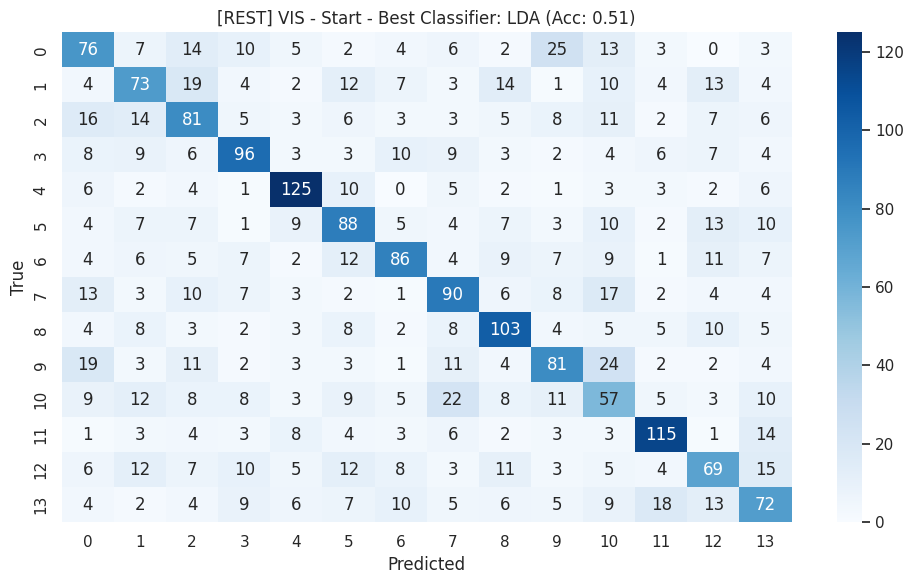

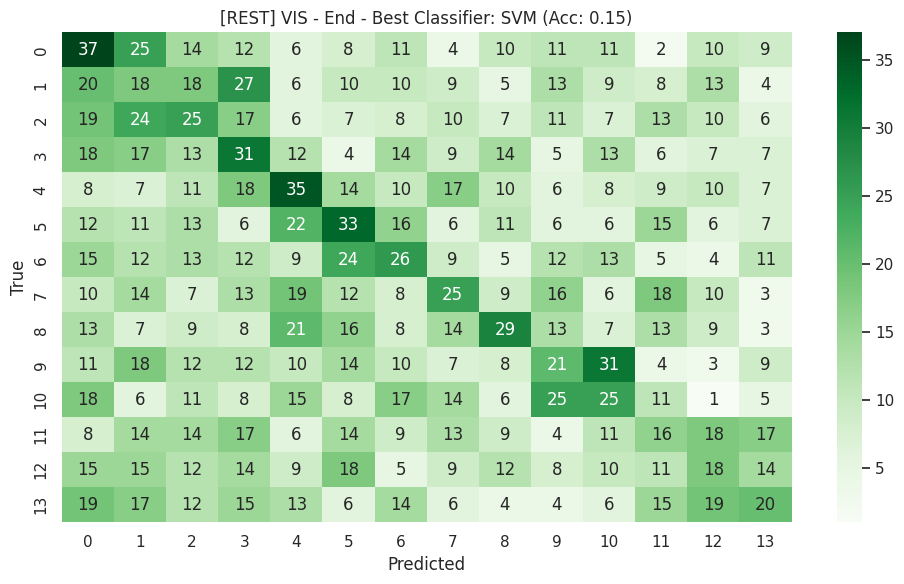

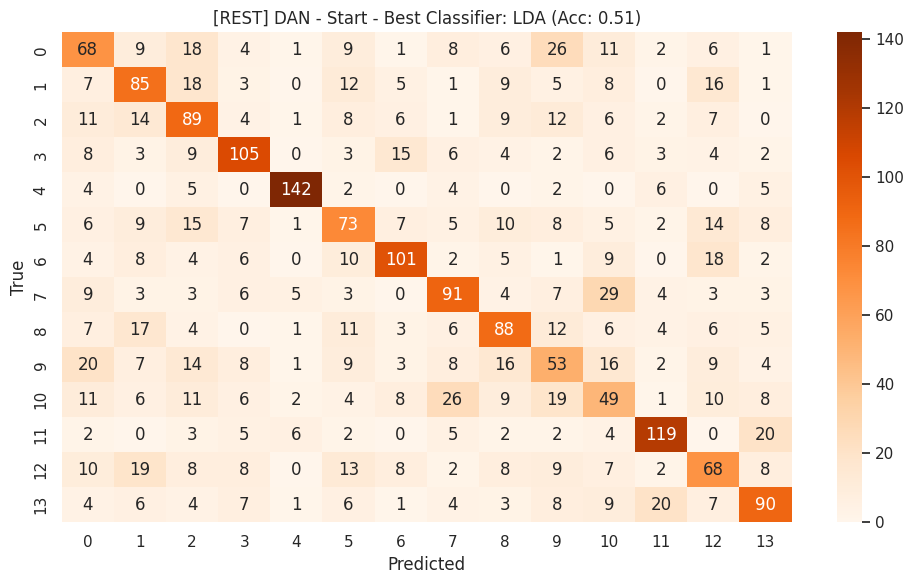

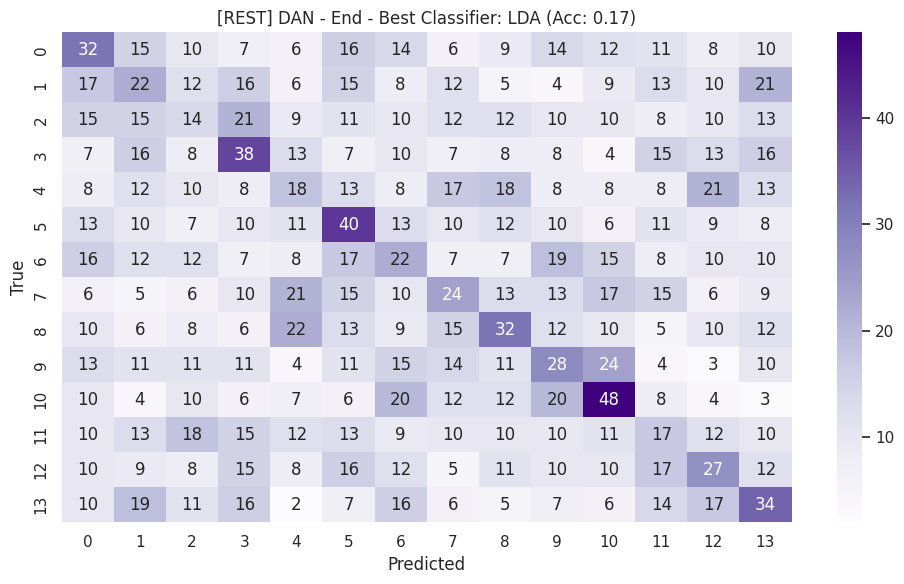

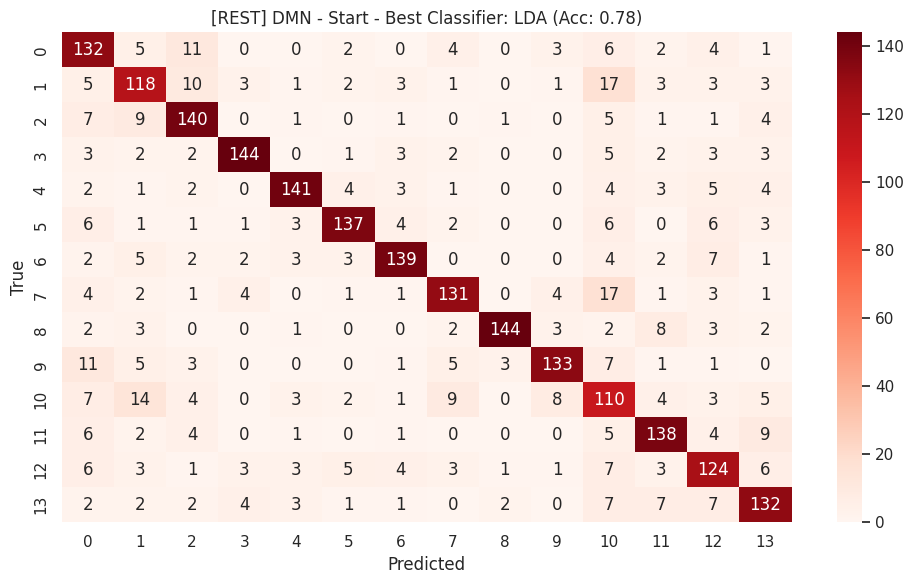

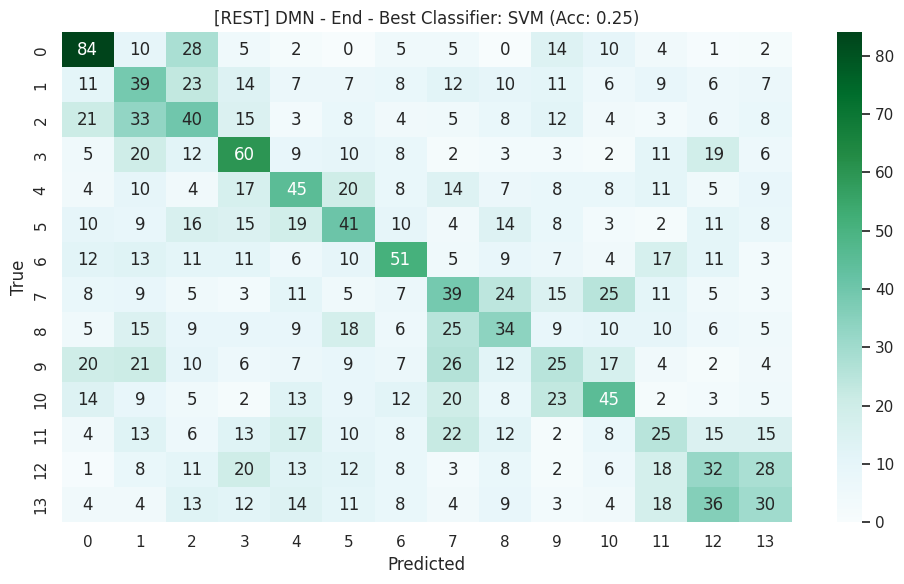

In [43]:
# Defining colors for each matrix
color_maps = ["Blues", "Greens", "Oranges", "Purples", "Reds", "BuGn"]

# Function to find best classifier
def best_classifier_name(accuracy_dict):
    return max(accuracy_dict.items(), key=lambda x: x[1])[0]

# Function to calculate confusion matrix
def compute_confusion_matrix(X, y, clf_name):
    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    if clf_name == "QDA":
        clf = QDA()
    elif clf_name == "NB":
        clf = GaussianNB()
    elif clf_name == "LDA":
        clf = LDA()
    elif clf_name == "KNN":
        clf = KNeighborsClassifier(n_neighbors=5)
    elif clf_name == "SVM":
        clf = SVC(kernel='linear', C=1)
    else:
        raise ValueError("Unknown classifier")

    # Data pre-treatment
    X = np.clip(X, -1e6, 1e6)
    imputer_full = SimpleImputer(strategy='mean')
    X = imputer_full.fit_transform(X)

    y_true = []
    y_pred = []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

        y_true.extend(y_test)
        y_pred.extend(preds)

    return confusion_matrix(y_true, y_pred)

# Build the rest accuracy dictionary
all_accuracies_rest = {
    "VIS": {
        "start": {
            "QDA": qda_rest_results["VIS"]["start"],
            "NB": naive_bayes_rest_results["VIS"]["start"],
            "LDA": lda_rest_results["VIS"]["start"],
            "KNN": knn_rest_results["VIS"]["start"],
            "SVM": svm_rest_results["VIS"]["start"]
        },
        "end": {
            "QDA": qda_rest_results["VIS"]["end"],
            "NB": naive_bayes_rest_results["VIS"]["end"],
            "LDA": lda_rest_results["VIS"]["end"],
            "KNN": knn_rest_results["VIS"]["end"],
            "SVM": svm_rest_results["VIS"]["end"]
        }
    },
    "DAN": {
        "start": {
            "QDA": qda_rest_results["DAN"]["start"],
            "NB": naive_bayes_rest_results["DAN"]["start"],
            "LDA": lda_rest_results["DAN"]["start"],
            "KNN": knn_rest_results["DAN"]["start"],
            "SVM": svm_rest_results["DAN"]["start"]
        },
        "end": {
            "QDA": qda_rest_results["DAN"]["end"],
            "NB": naive_bayes_rest_results["DAN"]["end"],
            "LDA": lda_rest_results["DAN"]["end"],
            "KNN": knn_rest_results["DAN"]["end"],
            "SVM": svm_rest_results["DAN"]["end"]
        }
    },
    "DMN": {
        "start": {
            "QDA": qda_rest_results["DMN"]["start"],
            "NB": naive_bayes_rest_results["DMN"]["start"],
            "LDA": lda_rest_results["DMN"]["start"],
            "KNN": knn_rest_results["DMN"]["start"],
            "SVM": svm_rest_results["DMN"]["start"]
        },
        "end": {
            "QDA": qda_rest_results["DMN"]["end"],
            "NB": naive_bayes_rest_results["DMN"]["end"],
            "LDA": lda_rest_results["DMN"]["end"],
            "KNN": knn_rest_results["DMN"]["end"],
            "SVM": svm_rest_results["DMN"]["end"]
        }
    }
}

# Confusion matrix for the best classifier for each network for both start and end
cm_index = 0
for net in ["VIS", "DAN", "DMN"]:
    for part in ["start", "end"]:
        best_clf_rest = best_classifier_name(all_accuracies_rest[net][part])
        X = eval(f"X_{net.lower()}_rest_{part}")
        y = eval(f"y_{net.lower()}_rest_{part}")

        cm = compute_confusion_matrix(X, y, best_clf_rest)

        cmap = color_maps[cm_index % len(color_maps)]
        cm_index += 1

        rest_accuracy = all_accuracies_rest[net][part][best_clf_rest]

        plt.figure(figsize=(10, 6))
        sns.heatmap(cm, cmap=cmap, fmt="d", annot=True)
        plt.title(f"[REST] {net} - {part.capitalize()} - Best Classifier: {best_clf_rest} (Acc: {rest_accuracy:.2f})")
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()

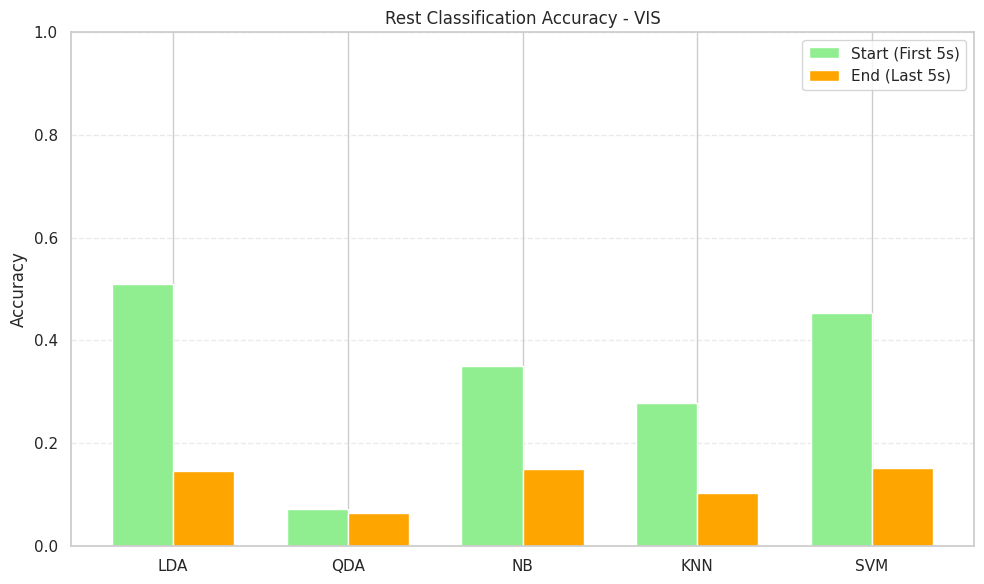

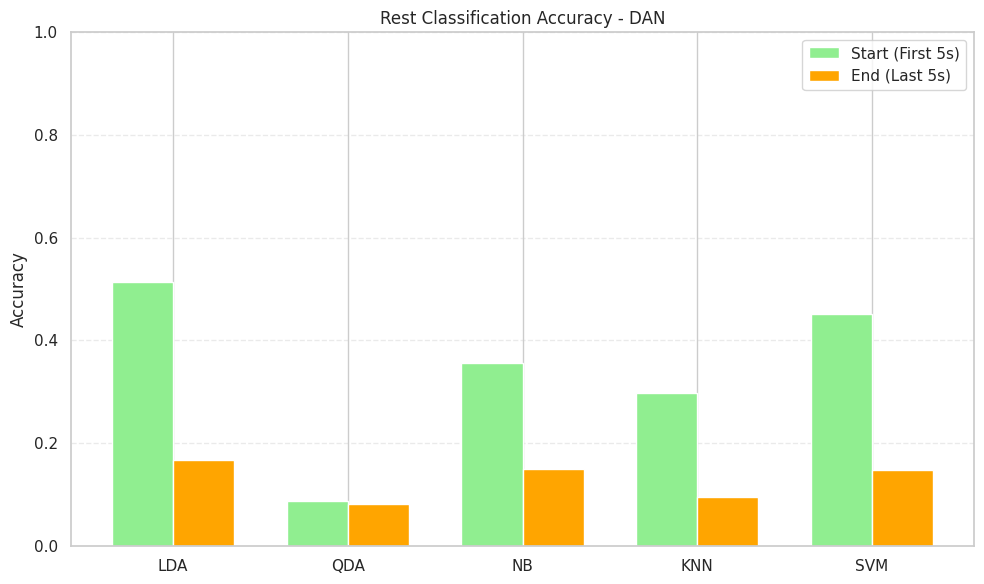

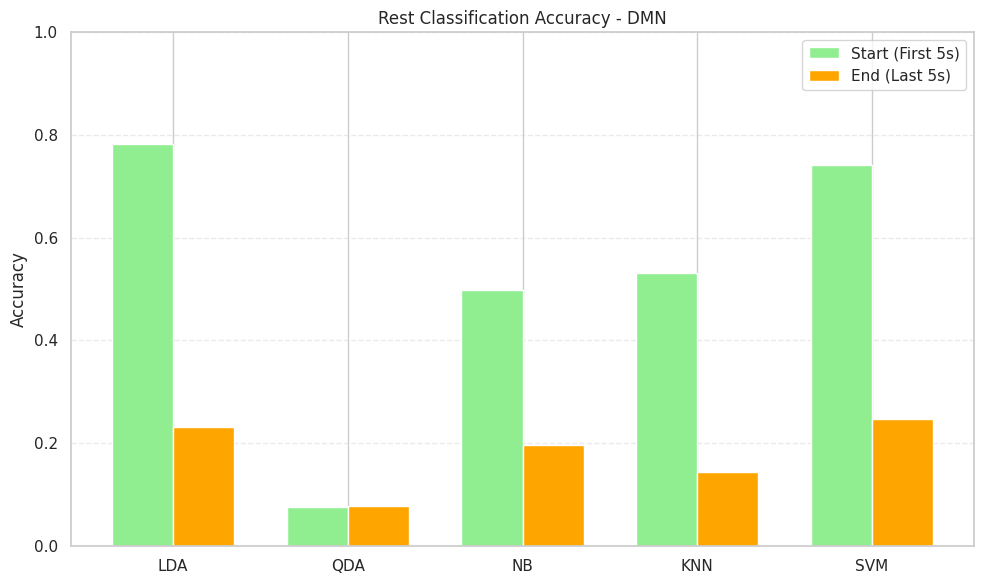

In [44]:
# Plot rest classification accuracy
def plot_rest_accuracy_bars(rest_accuracies):
    classifiers = ["LDA", "QDA", "NB", "KNN", "SVM"]
    networks = ["VIS", "DAN", "DMN"]

    for net in networks:
        start_scores = [rest_accuracies[net]["start"][clf] for clf in classifiers]
        end_scores = [rest_accuracies[net]["end"][clf] for clf in classifiers]

        x = np.arange(len(classifiers))
        width = 0.35

        plt.figure(figsize=(10, 6))
        plt.bar(x - width/2, start_scores, width, label='Start (First 5s)', color='lightgreen')
        plt.bar(x + width/2, end_scores, width, label='End (Last 5s)', color='orange')

        plt.xticks(x, classifiers)
        plt.ylim(0, 1)
        plt.ylabel("Accuracy")
        plt.title(f"Rest Classification Accuracy - {net}")
        plt.legend()
        plt.grid(axis='y', linestyle='--', alpha=0.4)
        plt.tight_layout()
        plt.show()

plot_rest_accuracy_bars(all_accuracies_rest)

# Bonus

In [48]:
#Importing additional libraries

from sklearn.model_selection import GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

Part 1 - Bonus

In [50]:
#Evaluating New Classifiers Only (on 5s start and end features) - movie

bonus_classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "Logistic Regression": LogisticRegression(max_iter=500),
    "MLP": MLPClassifier(
        hidden_layer_sizes=(50,),       # smaller net
        max_iter=200,
        early_stopping=True,            # stop early if plateau
        solver='adam',
        random_state=42
    )
}


# Evaluation function with 10-fold CV
def evaluate_model_kfold_10(X, y, clf, verbose=False):

    # Evaluate a classifier using 10-fold cross-validation, with proper preprocessing.

    X = np.clip(X, -1e6, 1e6)
    X = SimpleImputer(strategy='mean').fit_transform(X)

    kf = KFold(n_splits=10, shuffle=True, random_state=42)
    y_pred, y_true = [], []

    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        clf.fit(X_train, y_train)
        y_pred.extend(clf.predict(X_test))
        y_true.extend(y_test)

    return accuracy_score(y_true, y_pred)


# Running on all networks and storing results - start data
networks_start = {
    "VIS": (X_vis_start, y_vis_start),
    "DAN": (X_dan_start, y_dan_start),
    "DMN": (X_dmn_start, y_dmn_start)
}

bonus_results_5s_kfold = {}

for net, (X, y) in networks_start.items():
    bonus_results_5s_kfold[net] = {}
    for clf_name, clf in bonus_classifiers.items():
        acc = evaluate_model_kfold_10(X, y, clf, verbose=True)
        bonus_results_5s_kfold[net][clf_name] = acc

Best Classifier and Accuracy for Movie - Start Segment:
VIS: LDA (Acc: 0.5223)
DAN: LDA (Acc: 0.5550)
DMN: LDA (Acc: 0.8609)


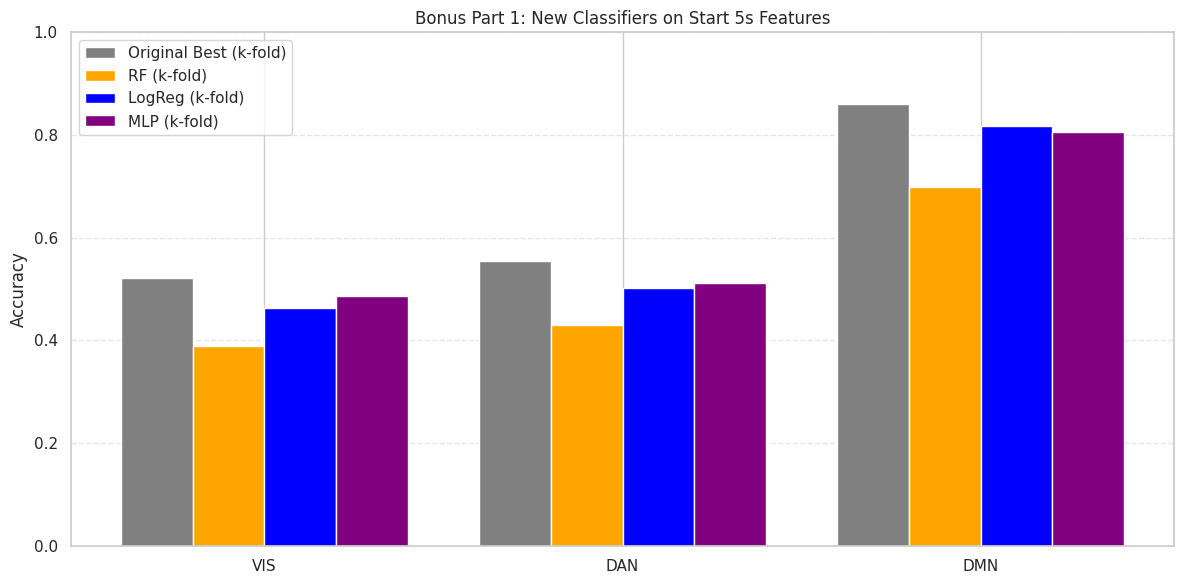

In [55]:
# Bar plot comparing original classifiers vs bonus models

labels = ["VIS", "DAN", "DMN"]
x = np.arange(len(labels))
width = 0.2

# Get your original best accuracy (from LDA, QDA, NB, KNN, SVM) for the start segment
original_best_start = {
    net: max(all_accuracies[net]["start"].items(), key=lambda item: item[1])
    for net in labels
}

print("Best Classifier and Accuracy for Movie - Start Segment:")
for net, (clf_name, acc) in original_best_start.items():
    print(f"{net}: {clf_name} (Acc: {acc:.4f})")


fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width*1.5, [original_best_start[n][1] for n in labels], width, label="Original Best (k-fold)", color="gray")
ax.bar(x - width/2, [bonus_results_5s_kfold[n]["Random Forest"] for n in labels], width, label="RF (k-fold)", color="orange")
ax.bar(x + width/2, [bonus_results_5s_kfold[n]["Logistic Regression"] for n in labels], width, label="LogReg (k-fold)", color="blue")
ax.bar(x + width*1.5, [bonus_results_5s_kfold[n]["MLP"] for n in labels], width, label="MLP (k-fold)", color="purple")

ax.set_ylabel("Accuracy")
ax.set_title("Bonus Part 1: New Classifiers on Start 5s Features")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Based on the following graph we can see that the new classifiers (RF, LogReg, MLP) did not provide better accuracy scores when compared to the best classification model used - LDA, when running on 5 seconds start data for "Movie" part.

Part 2 - Bonus

In [56]:
# Trying a new feature — STD across time

# Instead of slicing the signal, we use the standard deviation across time for each region in a clip.

# Feature extraction: STD per clip
def extract_std_features_all_subjects(data_array):

    # Returns STD across time per region per clip across all subjects.

    X_all, y_all = [], []

    for subj in range(170):
        subject_matrix = data_array[subj]  # shape: (14, 50, 34)
        for clip_idx in range(14):
            clip_data = subject_matrix[clip_idx]
            std_feat = np.std(clip_data, axis=0)
            X_all.append(std_feat)
            y_all.append(clip_idx)

    return np.array(X_all), np.array(y_all)

LDA Accuracy Comparison (5s Start vs STD Feature):
VIS - 5s Start: 0.5223 | STD Feature: 0.3958
DAN - 5s Start: 0.5550 | STD Feature: 0.3845
DMN - 5s Start: 0.8609 | STD Feature: 0.7349


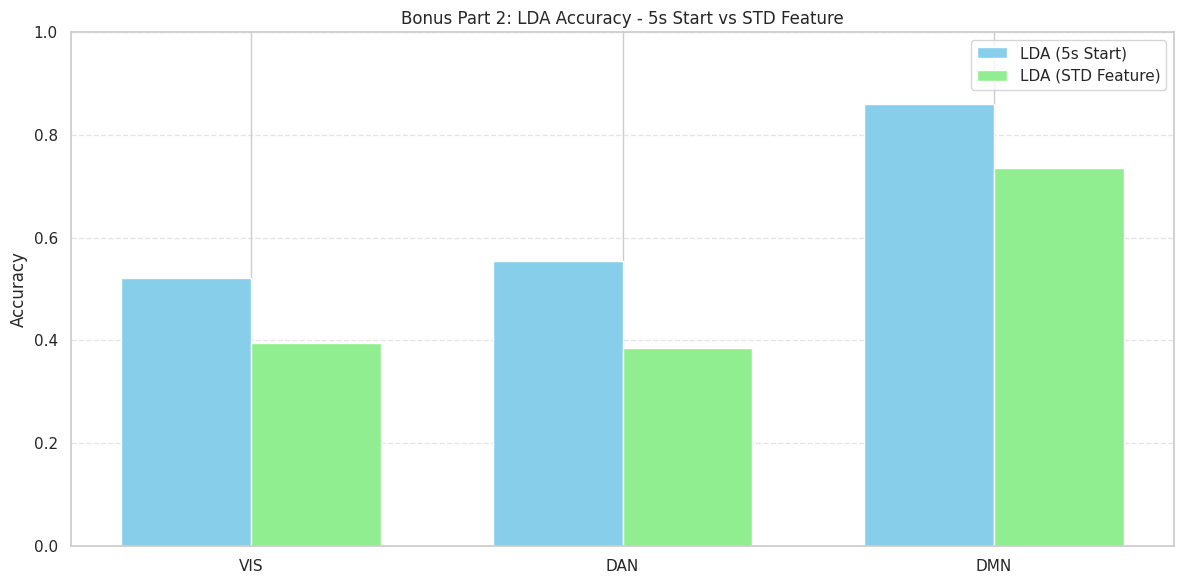

In [57]:
# Bar plot of new feature (STD) vs original best from 5s features
labels = ["VIS", "DAN", "DMN"]
x = np.arange(len(labels))
width = 0.35

# Calculate LDA accuracy with STD features for each network
lda_std_accuracies = {}
movie_networks_data = {"VIS": movie_VIS, "DAN": movie_DAN, "DMN": movie_DMN}

for net, data in movie_networks_data.items():
    X_std, y_std = extract_std_features_all_subjects(data)
    acc = evaluate_model_kfold_10(X_std, y_std, LDA()) # Use LDA classifier
    lda_std_accuracies[net] = acc

print("LDA Accuracy Comparison (5s Start vs STD Feature):")
for net in labels:
    print(f"{net} - 5s Start: {lda_results[net]['start']:.4f} | STD Feature: {lda_std_accuracies[net]:.4f}")


fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - width/2, [lda_results[n]['start'] for n in labels], width, label="LDA (5s Start)", color="skyblue")
ax.bar(x + width/2, [lda_std_accuracies[n] for n in labels], width, label="LDA (STD Feature)", color="lightgreen")

ax.set_ylabel("Accuracy")
ax.set_title("Bonus Part 2: LDA Accuracy - 5s Start vs STD Feature")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Based on the following graph we can see that the new method of using the standard deviation across time for each region in a clip instead of slicing the signal did not provide better results when used on the best original classifier - LDA, compared to the its results when using the original 5 seconds method (we chosed to focus on the 5 seconds start part in this case).

Part 3 - Bonus

In [61]:
# K-Fold vs Group K-Fold — LDA on 5s start feature - VIS, Movie

# Building dataset with subject IDs
def build_dataset_with_subject_ids(subject_data_dict, clip_part='start'):
    X_list, y_list, subject_ids = [], [], []

    for subj, (X_subj, y_subj, _) in subject_data_dict.items():
        if clip_part == 'start':
            X_selected = X_subj[::2]
            y_selected = y_subj[::2]
        else:
            X_selected = X_subj[1::2]
            y_selected = y_subj[1::2]

        X_list.append(X_selected)
        y_list.append(y_selected)
        subject_ids.extend([subj] * len(X_selected))

    return np.vstack(X_list), np.hstack(y_list), np.array(subject_ids)


# Comparing Group K-Fold vs regular K-Fold
def evaluate_lda_groupkfold(X, y, groups, k=10):
    X = np.clip(X, -1e6, 1e6)
    X = SimpleImputer(strategy='mean').fit_transform(X)

    gkf = GroupKFold(n_splits=k)
    y_pred, y_true = [], []

    for train_idx, test_idx in gkf.split(X, y, groups=groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        clf = LDA()
        clf.fit(X_train, y_train)
        y_pred.extend(clf.predict(X_test))
        y_true.extend(y_test)

    return accuracy_score(y_true, y_pred)


# LDA with both K-Fold and Grouped K-Fold, Movie
X_dmn_start, y_dmn_start, subj_ids = build_dataset_with_subject_ids(subject_data_movie_VIS, "start")

acc_lda_kfold = evaluate_model_kfold_10(X_vis_start, y_vis_start, LDA())
acc_lda_group = evaluate_lda_groupkfold(X_vis_start, y_vis_start, subj_ids)

print(f"BONUS PART 3 - LDA on VIS-start")
print(f"Regular K-Fold : {acc_lda_kfold:.4f}")
print(f"Group K-Fold   : {acc_lda_group:.4f}")

BONUS PART 3 - LDA on VIS-start
Regular K-Fold : 0.5223
Group K-Fold   : 0.5261


Based on the following accuracy results, we can see that Group K-Fold had almost the same accuracy score as the regular K-Fold method when used on LDA, VIS based on movie data